# 1. Background information on the dataset

## Features of Dataset

1. **Gender**: (0: 'Female', 1: 'Male')
2. **Age**: Patient's age in years.
3. **Hypertension**: (0 : No history of hypertension, 1: History of hypertension)
4. **Heart Disease**: (0: No history of heart disease, 1: History of heart disease)
5. **Ever Married**: (0: Patient has not been married before, 1: Patient has been married before)
6. **Work Type**: (0: 'Govt_job', 1: 'Never_worked', 2: 'Private', 3: 'Self-employed', 4: 'children')
7. **Residence Type**: (0: 'Rural', 1: 'Urban')
8. **Average Glucose Level**: Numeric data representing the average patient's glucose level.
9. **BMI**: Numeric data representing Body Mass Index.
10. **Smoking Status**: (0: 'Unknown', 1: 'formerly smoked', 2: 'never smoked', 3: 'smokes')

Before data cleaning, there were 5110 rows of data. However, there were "NaN" values under "BMI" and an anomaly of "Other" under "Gender". Hence, after data cleaning, we are left with 4908 rows of data.

## Objective

Our primary goal is to develop a predictive model that accurately identifies individuals at risk of experiencing a stroke based on various demographic, lifestyle, and health-related factors provided in the dataset.

# 2. Libraries and packages

## Tools and Libraries

For this project, we will utilize Python along with the following libraries for data analysis, machine learning, and data visualization. Below are the main libraries we will be using:

- **Pandas**: Used for data manipulation and analysis.
- **Matplotlib** and **Seaborn**: Employed for data visualization tasks.
- **Scikit-learn**: Utilized for various machine learning tasks such as data preprocessing, model training, and evaluation.
- **Imbalanced-learn**: Employed for addressing class imbalance issues within the dataset.


In [1]:
# Importing necessary packages
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Set seaborn style
sb.set()

# Import models and tools from Scikit-Learn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import imbalanced learn package
import imblearn
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

# 2. Import cleaned dataset

In [2]:
# Import the data set
traindata = pd.read_csv('cleaned_data.csv')
traindata.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,1,80.0,0,1,1,2,0,105.92,32.5,2,1
2,0,49.0,0,0,1,2,1,171.23,34.4,3,1
3,0,79.0,1,0,1,3,0,174.12,24.0,2,1
4,1,81.0,0,0,1,2,1,186.21,29.0,1,1


# 3. Addressing the imbalanced dataset

## 3.1 The metric trap

One of the challenge when handling unbalanced datasets is the choice of evaluation metrics for our models. Replying on simpler metrics such as `accuracy_score` can lead to misleading conclusions. In datasets where class imbalances are prominent, a classifier might achieve a seemingly high accuracy rate by consistently predicting the most frequent class without performing any analysis of the features. This will produce a high accuracy rate. However, the high accuracy is inherently deceptive.

To prove that the metric trap exists, we will conduct a simple experiment without feature engineering.

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id', 'work_type', 'Residence_type', 'stroke' columns
labels = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'smoking_status', 'age', 
          'avg_glucose_level', 'bmi']

X = traindata[labels]
y = traindata['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 94.40%


Modify the code to use only one feature which should drastically reduce the accuracy score of the classifier.

In [4]:
# Using only one feature
model = XGBClassifier()
model.fit(X_train[['gender']], y_train)
y_pred = model.predict(X_test[['gender']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 94.81%


As observed, the accuracy rate did not change drastically as mentioned above. It only increased marginally from 94.45% to 95.04%, indicating a difference of merely 0.59%. This minute variance emphasizes the significance of selecting appropriate evaluation metrics for unbalanced datasets.

# 4. Model 1: Gaussian Naive Bayes

Gaussian Naive Bayes (GNB) is a classification algorithm widely utilized in machine learning due to its simplicity, efficiency, and effectiveness, particularly in scenarios involving high-dimensional or text data. It operates on the principles of Bayes' theorem, which calculates the probability of a hypothesis given observed evidence.

The "naive" characteristic of GNB arises from its assumption of feature independence within each class. Despite this assumption's potential limitations in real-world scenarios, GNB can still deliver strong performance, especially when features are approximately independent or when the assumption minimally impacts classification accuracy.

GNB presupposes that continuous-valued features in the dataset adhere to a Gaussian (normal) distribution within each class. This simplifies the likelihood function calculation, enabling straightforward parameter estimation through the mean and variance of each feature within each class.

One of GNB's key advantages lies in its requirement for minimal training data compared to other algorithms. It boasts computational efficiency and quick training capabilities. However, its performance may suffer if the assumption of normality is violated or if strong correlations exist among the features.

### Step 1: Separate predictors and responses

In [5]:
# Splitting the data into input data features and target
columns_to_drop = ['stroke', 'work_type', 'Residence_type']
predictors = traindata.drop(columns=columns_to_drop)
stroke = traindata['stroke']

In [6]:
predictors.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,228.69,36.6,1
1,1,80.0,0,1,1,105.92,32.5,2
2,0,49.0,0,0,1,171.23,34.4,3
3,0,79.0,1,0,1,174.12,24.0,2
4,1,81.0,0,0,1,186.21,29.0,1


After conducting feature importance analysis using chi-square, ANOVA tests, and Random Forest alongside our domain knowledge, we concluded that `work_type` and `Residence_type` do not contribute significantly to predicting whether a person has a stroke or not. Therefore, based on both statistical analysis and domain expertise, we have decided to remove these less informative features from our dataset.

This decision is crucial for improving the efficiency and effectiveness of our predictive model. By eliminating irrelevant features, we aim to enhance the model's ability to identify meaningful patterns and relationships in the data, ultimately leading to more accurate predictions of stroke risk. Additionally, reducing the number of features can help mitigate the risk of overfitting and enhance the model's interpretability.

Overall, this refined feature selection process aligns with best practices in machine learning and ensures that our model focuses on the most relevant predictors, thereby improving its overall performance and utility in real-world applications.

### Step 2: Split the dataset into training and testing datasets in 8:2 ratio 

In [7]:
# Split the Dataset into Train and Test
predictors_train, predictors_test, stroke_train, stroke_test = train_test_split(predictors, stroke, test_size=0.2, random_state=42)

In [8]:
print("Number transactions x_train dataset: ", stroke_train.shape)
print("Number transactions y_train dataset: ", predictors_train.shape)
print("Number transactions x_test dataset: ", stroke_test.shape)
print("Number transactions y_test dataset: ", predictors_test.shape)

Number transactions x_train dataset:  (3926,)
Number transactions y_train dataset:  (3926, 8)
Number transactions x_test dataset:  (982,)
Number transactions y_test dataset:  (982, 8)


### Step 3: Data Preprocessing with Standard Scaling and SMOTE-Tomek Resampling (feature scaling and engineering)

In [9]:
# Define the StandardScaler
scaler = StandardScaler()

# Define the SMOTETomek sampler
smote_tomek = SMOTETomek(random_state=42)

# Define the pipeline including StandardScaler, SMOTETomek
pipeline = Pipeline([
    ('scaling', scaler),  # Scaling step
    ('sampling', smote_tomek),  # SMOTETomek step
    # Add other preprocessing steps or model training steps here
])

# Apply the pipeline to the training data
predictors_resampled_scaled, stroke_resampled = pipeline.fit_resample(predictors_train, stroke_train)

**SMOTE-Tomek**:

SMOTE-Tomek is a hybrid resampling technique designed to address imbalanced datasets by combining the strengths of SMOTE oversampling and Tomek links undersampling. It generates synthetic samples for the minority class while simultaneously removing Tomek links, resulting in a balanced and cleaner dataset. The benefits of using SMOTE-Tomek include improved class balance, reduced risk of overfitting, enhanced generalization, noise reduction, and potentially better model performance. By creating a more representative training set, SMOTE-Tomek contributes to more reliable and accurate predictions in machine learning models, making it a valuable tool for handling imbalanced data.

**StandardScalar**:

Data scaling is essential in preparing our data for modeling , particularly when features have different scales or units. In our case, some features may have values that are on entirely different scales. For instance, `age` ranges from 10 to 82, while `avg_glucose_level` ranges from 55 to 271.

Standardization ensures that all features are transformed to have a mean of 0 and a standard deviation of 1. By doing so, we can ensure that each feature contributes equally to the analysis and prevents features with larger scales from dominating the model's training process.

In the absence of standardization, features with larger scales may have a disproportionately larger impact on the model's outcome, potentially biasing the predictions. Therefore, standardizing the features helps our model make fair and unbiased predictions based on the relative importance of each feature.

Also, during scaling, we fit the data on the training data and transform the test data from information based on the training data to prevent data leakage. If these parameters were computed using the entire dataset, information from the test data would inadvertently leak into the training process, compromising the model's ability to generalize to new, unseen data.

### Step 4: Compute the accuracy of Gaussian Naive Bayes Model

In [10]:
#Create the Naive Bayes classifier
nb = GaussianNB()

# Train the classifier on the training data
nb.fit(predictors_train, stroke_train)

# Predict the classes of the test data
stroke_prediction = nb.predict(predictors_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(stroke_test, stroke_prediction)
print('Accuracy:', accuracy)

Accuracy: 0.8727087576374746


              precision    recall  f1-score   support

           0    0.96313   0.89989   0.93044       929
           1    0.18421   0.39623   0.25150        53

    accuracy                        0.87271       982
   macro avg    0.57367   0.64806   0.59097       982
weighted avg    0.92109   0.87271   0.89380       982



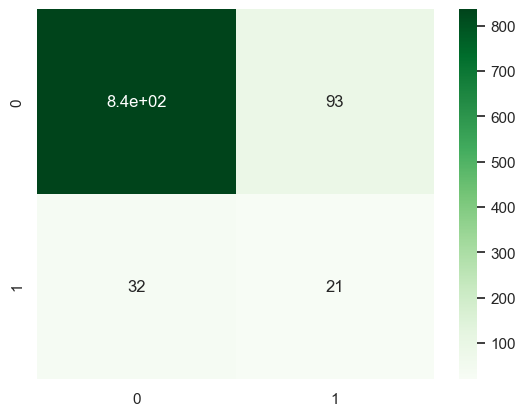

In [11]:
cm = confusion_matrix(stroke_test, stroke_prediction)
sb.heatmap(cm, annot=True, cmap='Greens')

# Create a classification report
cr = classification_report(stroke_test, stroke_prediction, digits = 5)
print(cr)

## 4.1. Optimisation of GaussianNB Model

The `GridSearchCV` function, found within the `model_selection` package of scikit-learn, facilitates the systematic exploration of predefined hyperparameters. It iterates through these hyperparameters and trains the estimator (model) on the training set. Ultimately, it enables the selection of the best parameters from the specified hyperparameters, enhancing model performance and optimization.

### Step 1: Insert smoothing parameters

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Instantiate Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Instantiate StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid including var_smoothing
param_grid = {'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Instantiate GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=cv, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(predictors_train, stroke_train)

# Access the best parameters
print("Best parameters found:", grid_search.best_params_)

# Access the best score
print("Best score found:", grid_search.best_score_)

# Use the best estimator to make predictions on the testing data
best_gnb = grid_search.best_estimator_
stroke_pred = best_gnb.predict(predictors_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(stroke_test, stroke_pred)
print("Accuracy:", accuracy)

Best parameters found: {'var_smoothing': 1e-05}
Best score found: 0.8830826080614578
Accuracy: 0.879837067209776


### Step 2: Recompute accuracy of the optimised model

In [13]:
from sklearn.preprocessing import PowerTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Define the hyperparameters to tune
parameters = {
    'var_smoothing': [1e-05]
}

# Perform Grid Search CV to find the best hyperparameters
grid_search = GridSearchCV(nb, parameters, scoring='roc_auc', cv=10, n_jobs=-1)
grid_search.fit(predictors_train, stroke_train)


# Make predictions on the test set using the best model
stroke_pred = grid_search.predict(predictors_test)

# Calculate the accuracy score
accuracy = accuracy_score(stroke_test, stroke_pred)
print("Accuracy Score: ", accuracy)

Accuracy Score:  0.879837067209776


              precision    recall  f1-score   support

           0    0.96343   0.90743   0.93459       929
           1    0.19626   0.39623   0.26250        53

    accuracy                        0.87984       982
   macro avg    0.57985   0.65183   0.59854       982
weighted avg    0.92202   0.87984   0.89832       982



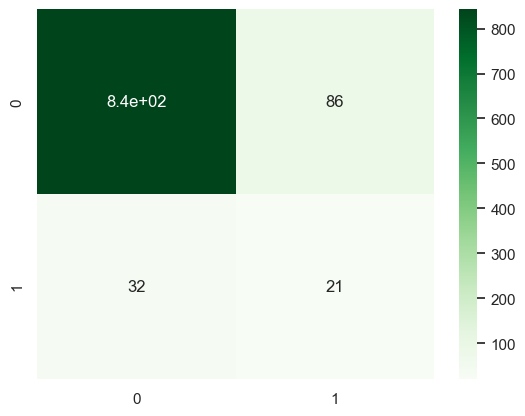

In [14]:
cm = confusion_matrix(stroke_test, stroke_pred)
sb.heatmap(cm, annot=True, cmap='Greens')

# Create a classification report
cr = classification_report(stroke_test, stroke_pred, digits=5)
print(cr)

After fine-tuning the hyperparameters of the GaussianNB model using the best parameters identified by `GridSearchCV`, specifically {'var_smoothing': 1e-05}, we observed a slight improvement in accuracy score, precision, and f1-score in predicting a patient with stroke.

# 5. Model 2: K-Nearest Neighbour

The k-Nearest Neighbors (KNN) classifier is a non-parametric supervised learning algorithm used for classification tasks. It determines the class label of a new data point based on the class labels of its k nearest neighbors in the feature space. KNN operates on the principle that similar data points tend to belong to the same class. During training, KNN stores all available data points and their class labels. When making predictions for a new data point, KNN calculates distances to all other data points and selects the k nearest neighbors. It then assigns the class label to the new data point based on majority voting among its k neighbors. KNN does not explicitly learn a decision boundary but determines it implicitly from the distribution of data points. It makes no assumptions about the underlying data distribution and is a "lazy learner" as it memorizes training data instead of learning a model. KNN is suitable for binary and multi-class classification tasks and can handle datasets with a large number of features. However, it may suffer from computational inefficiency with large training datasets due to calculating distances for prediction.

### Step 1: Putting data into KNN Model

In [15]:
# Create a KNN classifier with k=1 since it leads to the lowest error rate
knn = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier on the training data
knn.fit(predictors_train, stroke_train)

# Use the trained model to make predictions on the testing data
stroke_pred = knn.predict(predictors_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(stroke_test, stroke_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9409368635437881


              precision    recall  f1-score   support

           0    0.94758   0.99247   0.96951       929
           1    0.22222   0.03774   0.06452        53

    accuracy                        0.94094       982
   macro avg    0.58490   0.51510   0.51701       982
weighted avg    0.90844   0.94094   0.92066       982



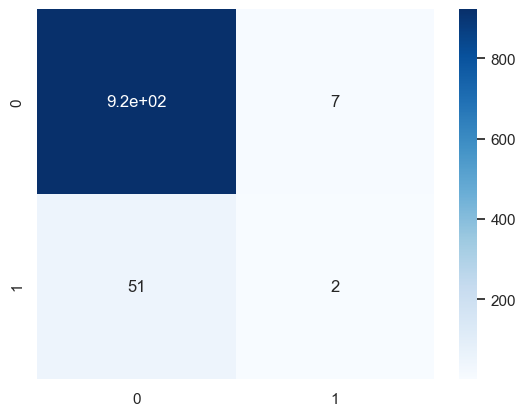

In [16]:
cm = confusion_matrix(stroke_test, stroke_pred)
sb.heatmap(cm, annot=True, cmap='Blues')

# Create a classification report
cr = classification_report(stroke_test, stroke_pred, digits=5)
print(cr)

## 5.1. Optimisation of KNN Model

Once again, we used `GridSearchCV` and evaluate the performance of a K-Nearest Neighbors (KNN) classifier by testing different values of the hyperparameter k, which represents the number of neighbors considered for classification. Iterating through k-values from 1 to 30, it calculates the error rate. This analysis helps in selecting an optimal k-value that minimizes the error rate for the given dataset.

### Step 1: Find the optimal k-value to optmise the KNN model

In [17]:
# Create a list that will store the average error rate value produced by different k-values
error_rate = []

# Test k-values from 1 to 30
for i in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(predictors_train, stroke_train)
    stroke_prediction = knn.predict(predictors_test)
    error_rate.append(np.mean(stroke_prediction != stroke_test))

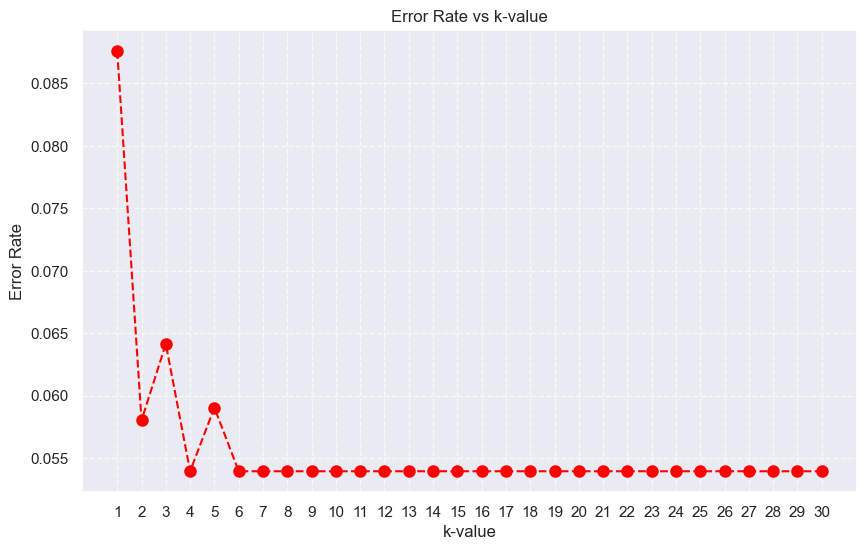

In [18]:
# Plotting the error rate vs k-value
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), error_rate, marker="o", color="red", linestyle="dashed", markersize=8)
plt.title("Error Rate vs k-value")
plt.xlabel("k-value")
plt.ylabel("Error Rate")
plt.xticks(range(1, 31))
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

# Define the parameter grid
param_grid = {'n_neighbors': [4, 6, 10, 12]}

# Instantiate KNN classifier
knn = KNeighborsClassifier()

# Instantiate StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Instantiate GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(predictors_train, stroke_train)

# Access the best parameters
print("Best parameters found:", grid_search.best_params_)

# Access the best score
print("Best score found:", grid_search.best_score_)

# Use the best estimator to make predictions on the testing data
best_knn = grid_search.best_estimator_
stroke_pred = best_knn.predict(predictors_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(stroke_test, stroke_pred)
print("Accuracy:", accuracy)

Best parameters found: {'n_neighbors': 10}
Best score found: 0.9602651496734251
Accuracy: 0.9460285132382892


In [20]:
# Create a KNN classifier with k=1 since it leads to the lowest error rate
knn = KNeighborsClassifier(n_neighbors=6)

# Train the KNN classifier on the training data
knn.fit(predictors_train, stroke_train)

# Use the trained model to make predictions on the testing data
stroke_pred = knn.predict(predictors_test)


# Evaluate the accuracy of the model
accuracy = accuracy_score(stroke_test, stroke_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9460285132382892


              precision    recall  f1-score   support

           0    0.94603   1.00000   0.97227       929
           1    0.00000   0.00000   0.00000        53

    accuracy                        0.94603       982
   macro avg    0.47301   0.50000   0.48613       982
weighted avg    0.89497   0.94603   0.91979       982



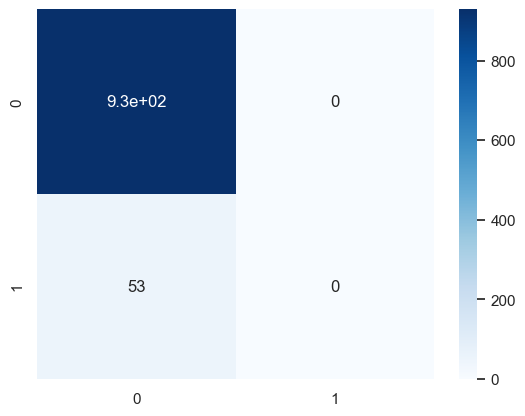

In [21]:
cm = confusion_matrix(stroke_test, stroke_pred)
sb.heatmap(cm, annot=True, cmap='Blues')

# Create a classification report
cr = classification_report(stroke_test, stroke_pred, digits = 5)
print(cr)

After fine-tuning the hyperparameters of the GaussianNB model using the best parameters identified by GridSearchCV, specifically {'n_neighbors': 10}, we observed a slight improvement in accuracy score but worse metrics for precision, recall, and f1-score in predicting a patient with stroke.

# 6. Model 3: eXtreme Gradient Boosting

XGBoost (eXtreme Gradient Boosting) is a highly efficient and scalable open-source machine learning library. It implements the gradient boosting algorithm, enhancing it with parallelization, regularization techniques, and hardware optimization. XGBoost builds an ensemble of decision trees sequentially, emphasizing difficult-to-classify instances through boosting. It incorporates L1 and L2 regularization to prevent overfitting and supports built-in cross-validation for robust evaluation.

### Step 1: Compute the accuracy of Gaussian Naive Bayes Model

In [22]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Train the classifier on the training data
xgb_classifier.fit(predictors_train, stroke_train)

# Predict the classes of the test data
stroke_prediction = xgb_classifier.predict(predictors_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(stroke_test, stroke_prediction)
print('Accuracy:', accuracy)

Accuracy: 0.9409368635437881


              precision    recall  f1-score   support

           0    0.94667   0.99354   0.96954       929
           1    0.14286   0.01887   0.03333        53

    accuracy                        0.94094       982
   macro avg    0.54476   0.50620   0.50144       982
weighted avg    0.90328   0.94094   0.91901       982



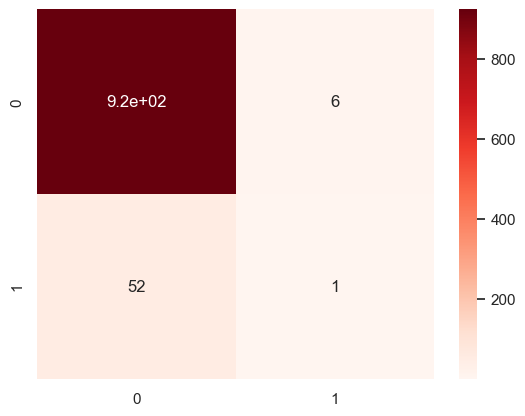

In [23]:
cm = confusion_matrix(stroke_test, stroke_prediction)
sb.heatmap(cm, annot=True, cmap='Reds')

# Create a classification report
cr = classification_report(stroke_test, stroke_prediction, digits = 5)
print(cr)

## 6.1. Optimisation of XGBoost Model

Once again, we used `GridSearchCV` to evaluate the best parameters to finetune our model.

### Step 1: Fine tune hyperparameters

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# Instantiate XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Instantiate StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Instantiate GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=cv, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(predictors_train, stroke_train)

# Access the best parameters
print("Best parameters found:", grid_search.best_params_)

# Access the best score
print("Best score found:", grid_search.best_score_)

# Use the best estimator to make predictions on the testing data
best_xgb = grid_search.best_estimator_
stroke_pred = best_xgb.predict(predictors_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(stroke_test, stroke_pred)
print("Accuracy:", accuracy)

Best parameters found: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.5}
Best score found: 0.960519926743489
Accuracy: 0.9460285132382892


### Step 2: Recompute accuracy of the optimised model

In [25]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Use the best parameters found from GridSearchCV
best_params = {
    'max_depth': 3,
    'learning_rate': 0.01,
    'n_estimators': 200,
    'gamma': 0,
    'subsample': 1.0,
    'colsample_bytree': 0.8
}

# Instantiate XGBoost classifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_params)

# Fit the classifier on the training data with the best parameters
best_xgb_classifier.fit(predictors_train, stroke_train)

# Predict the classes of the test data
stroke_pred = best_xgb_classifier.predict(predictors_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(stroke_test, stroke_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9460285132382892


              precision    recall  f1-score   support

           0    0.94603   1.00000   0.97227       929
           1    0.00000   0.00000   0.00000        53

    accuracy                        0.94603       982
   macro avg    0.47301   0.50000   0.48613       982
weighted avg    0.89497   0.94603   0.91979       982



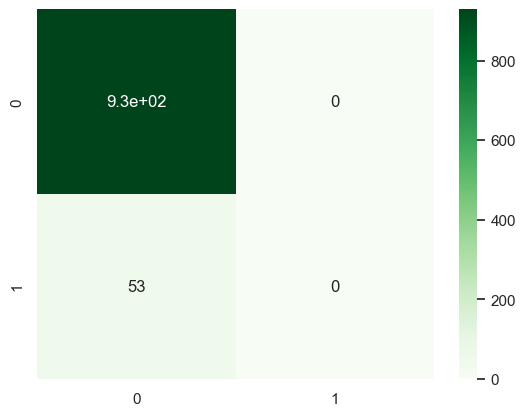

In [26]:
cm = confusion_matrix(stroke_test, stroke_pred)
sb.heatmap(cm, annot=True, cmap='Greens')

# Create a classification report
cr = classification_report(stroke_test, stroke_pred, digits=5)
print(cr)